In [1]:
import math
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import time
import random
from PIL import Image
import pickle
import joblib
import re

from sklearn import preprocessing
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate,Conv1D,MaxPooling2D,Activation
from keras.layers import BatchNormalization
from keras.layers import Embedding
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import keras_tuner
from tensorflow import keras
import tensorflow_hub as hub
#import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)

OSError: [Errno 16] Device or resource busy: '/kaggle/working'

In [2]:
data_df_k1000 = pd.read_csv("/kaggle/input/my-data/mscoco_train2014_k1000_50k.csv")
data_df_k1000.head(10)

,image_id,question,answer,answers,que_firstword
0,train2014/COCO_train2014_000000159768.jpg,What design is on the curtains?,stripes,"tan,stripes,stripes,stripes,stripes,stripes,st...",what
1,train2014/COCO_train2014_000000157176.jpg,Is it early morning?,no,"no,no,no,no,no,no,no,yes,no,no",is
2,train2014/COCO_train2014_000000224168.jpg,What is the cat in?,bowl,"bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl",what
3,train2014/COCO_train2014_000000322638.jpg,Is this bathroom finished?,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",is
4,train2014/COCO_train2014_000000577759.jpg,What tool is using to cut?,scissors,"scissors,scissors,scissors,scissors,scissors,s...",what
5,train2014/COCO_train2014_000000119743.jpg,What color is the helmet?,orange,"orange,orange,orange,orange,orange,orange,oran...",what
6,train2014/COCO_train2014_000000351033.jpg,Are both surfer's on their surfboards?,yes,"yes,yes,yes,no,yes,no,yes,yes,yes,yes",are
7,train2014/COCO_train2014_000000236772.jpg,Is this a normal toilet seat like everyone else?,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,no",is
8,train2014/COCO_train2014_000000211302.jpg,Are those chairs retro?,yes,"yes,yes,yes,yes,yes,no,yes,yes,yes,yes",are
9,train2014/COCO_train2014_000000218368.jpg,What brand is the man's phone?,apple,"iphone,apple,apple,iphone,apple,apple,apple,ip...",what


(427, 640, 3)
Is this man athletic?


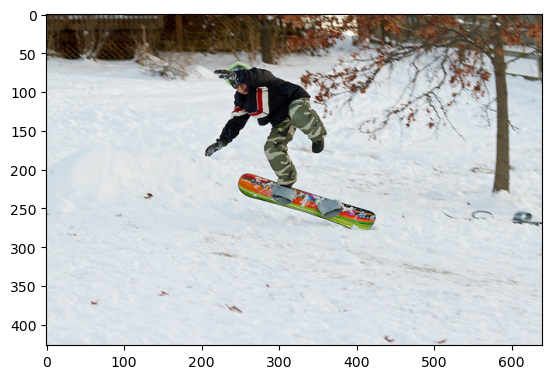

In [3]:
Image_dataset_path ='/kaggle/input/ms-coco/train2014/'
print_index = 280
image = Image_dataset_path + data_df_k1000.image_id[print_index]
image_vect = cv2.imread(image)
image_vect = cv2.cvtColor(image_vect, cv2.COLOR_BGR2RGB)

print(image_vect.shape)
print(data_df_k1000.question[print_index])
plt.imshow(image_vect)

In [4]:
def preprocess():
    data_df_k1000['question'] = data_df_k1000['question'].str.replace('?', '')
    data_df_k1000['question'] = data_df_k1000['question'].str.lower()
    
preprocess()

In [5]:
le = preprocessing.LabelEncoder()
le.fit(list(data_df_k1000['answer']))
data_df_k1000['class_label'] = le.transform(list(data_df_k1000['answer']))
print("Number of classes:"+ str(len(le.classes_)))
data_df_k1000.head(3)

Number of classes:1000


,image_id,question,answer,answers,que_firstword,class_label
0,train2014/COCO_train2014_000000159768.jpg,what design is on the curtains,stripes,"tan,stripes,stripes,stripes,stripes,stripes,st...",what,850
1,train2014/COCO_train2014_000000157176.jpg,is it early morning,no,"no,no,no,no,no,no,no,yes,no,no",is,583
2,train2014/COCO_train2014_000000224168.jpg,what is the cat in,bowl,"bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl",what,146


In [6]:
# to get 50k datapoints from dataset with same %count as in dataset

X = data_df_k1000[['image_id','question','answer','class_label']]
y = data_df_k1000['class_label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,
                                                  stratify=y,
                                                  #shuffle=True
                                                 ) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, 
                                                    stratify=y_train,
                                                    #shuffle=True 
                                                   ) 
print('X_train.shape:',X_train.shape)
print('y_train.shape:',y_train.shape)
print('X_val.shape:',X_val.shape)
print('y_val.shape:',y_val.shape)

X_train.shape: (42752, 4)
y_train.shape: (42752,)
X_val.shape: (5001, 4)
y_val.shape: (5001,)


In [7]:
vocab_size = 10000
embedding_dim = 256
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# column to list using Series.tolist()
question_list_train = X_train["question"].tolist()
#tokenizer part
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(question_list_train)

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,tokenizer,
                 #encoder,
                 Question_batch,Image_batch,Answer_label_batch,path, batch_size, dim=(224,224),
                 n_classes=1000,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        #self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.indexes = np.arange(len(Answer_label_batch))
        self.n_classes = n_classes
        self.shuffle = shuffle

        self.tokenizer = tokenizer
        #self.encoder = encoder
        self.Image_batch = Image_batch
        self.Question_batch = Question_batch
        self.Answer_label_batch = Answer_label_batch
        self.path = path
        
        #self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, index):
        
        Qstn = self.Question_batch[index * self.batch_size:(index + 1) * self.batch_size]
        IMG = self.Image_batch[index * self.batch_size:(index + 1) * self.batch_size]
        Ans = self.Answer_label_batch[index * self.batch_size:(index + 1) * self.batch_size]

        
        qstn = np.asarray([self.__get_question_(que) for que in Qstn])
        img = np.asarray([self.__get_Image_(self.path + i ) for i in IMG])
        ans = np.asarray([self.__get_output_(c) for c in Ans])
       
        return tuple([img, qstn]), ans

    def __get_question_(self, que):
    
        #que_arr = (pad_sequences(t.texts_to_sequences([X_que]), maxlen=22, padding='post'))[0]
        sequences = self.tokenizer.texts_to_sequences([que])
        sequence_padded = (pad_sequences(sequences, maxlen=max_length, padding='post'))[0]
        
        return sequence_padded

    def __get_Image_(self, path):

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize image as (224,224,3)
        resized_img = cv2.resize(img,self.dim)
        #normalize inage
        img = np.array(resized_img)/255.0
            
        return img

    def __get_output_(self, answer):
        return tf.keras.utils.to_categorical(answer, num_classes=self.n_classes)
        #return self.encoder.fit_transform(train_data[['answer']]).toarray()

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

batch = 32
traingen = DataGenerator(tokenizer,
                         #encoder,
                         list(X_train['question']),
                         list(X_train['image_id']),
                         list(y_train),
                         Image_dataset_path,
                         batch_size=batch,
                         )
valgen = DataGenerator(tokenizer,
                       #encoder,
                       list(X_val['question']),
                       list(X_val['image_id']),
                       list(y_val),
                       Image_dataset_path,
                       batch_size=batch,
                       )

In [9]:
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
#         tf.keras.layers.RandomBrightness(factor=0.2),
    ],
    name="img_augmentation",
)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train)
class_weights = dict(enumerate(class_weights))

In [16]:
pre_trained_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3), 
    include_top=True,
    weights="imagenet",
    pooling='avg')
for layer in pre_trained_model.layers:
    layer.trainable = False

regularizer = tf.keras.regularizers.l2(0.02)

for layer in pre_trained_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
            setattr(layer, attr, regularizer)
            


vgg19_fc2_output = (pre_trained_model.get_layer('fc2')).output
img = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(vgg19_fc2_output)
img = Dropout(0.2)(img)

input_layer_que = Input(shape=(50,))
#embedding = Embedding(1014, 300, weights=[embedding_matrix_vocab], input_length=100, trainable=False)(input_layer_que)
embedding = Embedding(input_dim=10000,output_dim=256,input_length=max_length)(input_layer_que)
lstm1 = LSTM(64, return_sequences=True)(embedding)
dropout1 = Dropout(0.5)(lstm1)
lstm2 = LSTM(64)(dropout1)
dropout2 = Dropout(0.5)(lstm2)
que = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(dropout2)

pointwise_mul = tf.math.multiply(que, img)

output = Dense(units=1000,activation='softmax',kernel_initializer="glorot_uniform")(pointwise_mul)

model_lstm_vgg19 = Model(inputs=[pre_trained_model.input,input_layer_que],outputs=output)

# # compile
# optimizer = tf.keras.optimizers.Adam()
# model_lstm_vgg19.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model_lstm_vgg19.summary()

574710816/574710816 [==============================] - 3s 0us/step


ValueError: Exception encountered when calling layer 'random_rotation' (type RandomRotation).

Attempt to convert a value (<keras.engine.functional.Functional object at 0x7c59e7f73df0>) with an unsupported type (<class 'keras.engine.functional.Functional'>) to a Tensor.

Call arguments received by layer 'random_rotation' (type RandomRotation):
  • inputs=<keras.engine.functional.Functional object at 0x7c59e7f73df0>
  • training=True

In [18]:
def create_model():
    # Create base model
    Size=224
    base_model = keras.applications.EfficientNetB7(
                                                    weights='imagenet',
                                                    input_shape=(Size, Size, 3),
                                                    include_top=False)
    # Freeze base model
    base_model.trainable = False
    regularizer = tf.keras.regularizers.l2(.010)

    for layer in base_model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                  setattr(layer, attr, regularizer)

    inputs = keras.Input(shape=(Size, Size, 3))
    # Apply random data augmentation
    x = img_augmentation(inputs)  

    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(x)

    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x) 
    encoded_image = tf.keras.layers.Flatten()(x)

    # A Language model
    # Encode the question into a vector
    question_input = Input(shape=(max_length,),dtype='int32',name='Question')
    embedded = Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_length)(question_input)
    encoded_question = tf.keras.layers.Bidirectional(LSTM(64,activation='relu'))(embedded)
#     dropout_encoded_question =  tf.keras.layers.Dropout(0.2)(encoded_question1) 
#     encoded_question = tf.keras.layers.Bidirectional(LSTM(128,activation='relu'))(dropout_encoded_question)
    
    # merge two model 
    merged = tf.keras.layers.concatenate([encoded_image,encoded_question])
    output = Dense(1000,activation='softmax')(merged)
    my_model = Model(inputs=[inputs,question_input],outputs=output)

    return my_model

In [26]:
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
# compile
def compile_and_run(model,lr,epoch,batch_size):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'],
                                 #options=run_opts
                                 )
        # vqa_model.fit([Training_pair[0],Training_pair[1]],
        #               train_answer_encoded,
        #               validation_data=([Validation_pair[0],Validation_pair[1]],val_answer_encoded),
        #               epochs=5,
        #               batch_size=128)

        checkpoint_filepath="/kaggle/working/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
        model_checkpoint_callback = ModelCheckpoint(filepath=
                                                    checkpoint_filepath,
                                                    monitor='val_accuracy',
                                                    verbose=0,
                                                    save_best_only=True,
                                                    mode='max')
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                         factor=0.2,
                                                         patience=2,
                                                         min_lr=0.001)
        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",

                                                        patience=3,
                                                        verbose=1,
                                                        mode="auto",
                                                        baseline=None,
                                                        restore_best_weights=False,
                                                        start_from_epoch=0,                   
        )
        history = model.fit(traingen,
                            batch_size=batch_size,
                            epochs=epoch,
                            verbose=1,
                            validation_data=valgen,
                            callbacks=[model_checkpoint_callback,
                                       reduce_lr,
                                      early_stop],
                            #class_weight = class_weights
                           )
        return history

In [ ]:
learning_rate=.0001
batch_size=32
epoch=10

model = create_model()
history_model = compile_and_run(model,learning_rate,epoch,batch_size)

In [23]:
vqa_Xception_Model.load_weights("/kaggle/working/weights-04-0.3251.hdf5")

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(10))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(Image_dataset_path+test_image_path[i]+'.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {le.inverse_transform(test_answer)[i]} \nPredicted Ans:
  {le.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')

In [40]:
from prettytable import PrettyTable
x2 = PrettyTable(["Model", "Datapoints", "Class Labels",  "Epochs","Optimizer", "Train Accuracy", "Validation Accuracy", "Test Accuracy"])
x2.add_row(["Biderectional LSTM + Xception", "50000", "1000",  "5","Adam(.003)", round(.4575,3),
            round(.3383,3), round(.3500,3)])
print(x2)

+-------------------------------+------------+--------------+--------+------------+----------------+---------------------+---------------+
|             Model             | Datapoints | Class Labels | Epochs | Optimizer  | Train Accuracy | Validation Accuracy | Test Accuracy |
+-------------------------------+------------+--------------+--------+------------+----------------+---------------------+---------------+
| Biderectional LSTM + Xception |   50000    |     1000     |   5    | Adam(.003) |     0.458      |        0.338        |      0.35     |
+-------------------------------+------------+--------------+--------+------------+----------------+---------------------+---------------+


In [29]:
# Import Keras 
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential

# Define CNN for Image Input
vision_model = Sequential()
vision_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
vision_model.add(Conv2D(64, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(128, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Flatten())

image_input = Input(shape=(224, 224, 3))
encoded_image = vision_model(image_input)

# Define RNN for language input
question_input = Input(shape=(50,), dtype='int32')
embedded_question = Embedding(input_dim=10000, output_dim=256, input_length=100)(question_input)
encoded_question = LSTM(256)(embedded_question)

# Combine CNN and RNN to create the final model
merged = keras.layers.concatenate([encoded_question, encoded_image])
output = Dense(1000, activation='softmax')(merged)
vqa_model = Model(inputs=[image_input, question_input], outputs=output)


In [32]:
new_model = tf.keras.models.load_model('/kaggle/working/weights-04-0.3251.hdf5')